In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !mkdir data2
# !mkdir data2/train
# !mkdir data2/train/image
# !mkdir data2/train/answer
# !mkdir data2/test
# !mkdir data2/test/image

In [264]:
# !unzip /content/drive/MyDrive/DACON/data2/dirty_mnist_2nd.zip -d /content/data2/train/image
# !unzip /content/drive/MyDrive/DACON/data2/test_dirty_mnist_2nd.zip -d /content/data2/test/image
# !cp /content/drive/MyDrive/DACON/data2/dirty_mnist_2nd_answer.csv /content/data2/train/answer
# !cp /content/drive/MyDrive/DACON/sample_submission.csv /content

### 문제정의
노이즈가 낀 img에서 특정 알파벳이 포함되어있는지를 찾는 멀티라벨 분류문제입니다.

img는 여러 알파벳과 노이즈(쓸모없는 단어 등)이 포함되어 있으며,
답안은 a-z와 대응되는 길이로 0, 1로 매핑된 csv입니다.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from google.colab import output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 디바이스 설정

In [5]:
answer = pd.read_csv('/content/data2/train/answer/dirty_mnist_2nd_answer.csv')

In [6]:
answer = answer.drop(columns='index')
answer

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
0,1,1,0,1,0,1,0,0,0,0,...,0,1,1,0,1,0,0,1,1,1
1,1,0,0,1,0,1,0,1,0,1,...,0,1,0,1,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,1,1,...,0,0,1,1,1,0,1,1,1,0
3,0,0,1,0,0,0,1,1,0,0,...,1,0,1,1,0,1,1,0,1,0
4,0,1,0,1,0,1,0,1,1,0,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,1,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,1,0
49996,0,1,0,1,0,1,1,1,0,1,...,0,1,1,1,0,1,0,0,0,1
49997,0,1,0,0,1,1,1,1,0,0,...,1,0,0,0,0,1,1,1,0,0
49998,0,1,1,1,0,0,1,1,0,1,...,0,1,1,1,0,0,0,1,0,0


In [7]:
# img 경로와 답안으로 구성된 metadata csv를 만드려고 합니다 

import os

root = '/content/data2/train'
image_path = '/content/data2/train/image'
image_paths = [os.path.join(image_path, path) for path in os.listdir(image_path)]

In [8]:
# img 경로
image_paths[:10]

['/content/data2/train/image/40692.png',
 '/content/data2/train/image/29381.png',
 '/content/data2/train/image/17029.png',
 '/content/data2/train/image/09223.png',
 '/content/data2/train/image/01373.png',
 '/content/data2/train/image/11850.png',
 '/content/data2/train/image/46592.png',
 '/content/data2/train/image/13629.png',
 '/content/data2/train/image/37193.png',
 '/content/data2/train/image/13381.png']

In [9]:
data = []
for i in range(len(image_paths)):
  a = image_paths[i]
  b = answer.iloc[i].tolist()
  data.append([a, b])

metadata = pd.DataFrame(columns=['path', 'target'], data=data)

In [10]:
# 경로와 답안이 저장된 메타데이터 완성
metadata.head(3)

,path,target
0,/content/data2/train/image/40692.png,"[1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, ..."
1,/content/data2/train/image/29381.png,"[1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, ..."
2,/content/data2/train/image/17029.png,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, ..."


In [103]:
metadata['target'][0]

[1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1]

In [11]:
# 이미지 경로를 입력하면 정규화하여 np array로 반환하는 함수
def get_image(path):
  img = cv2.imread(path)
  img = (img / 255).astype('float')
  return img

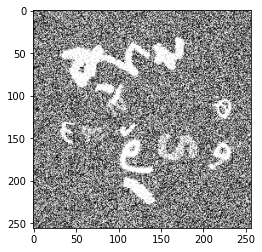

In [12]:
# 이미지 1개 시각화
plt.imshow(get_image(metadata['path'][0]))

In [13]:
# numpy 이미지의 shape 확인
get_image(metadata['path'][0]).shape

# 확인 결과 (256, 256, 3)로 3채널로 구성되었다.
# => 1채널(그레이스케일)로 바꿔도 되지만, 3채널로 학습된 프리트레인 모델을 쓸 것이라 그냥 두겠다
# => (H, W, C)의 형태롤 (C, H, W)로 바꿔주어야겠다. (이미지 증강단계에서)

(256, 256, 3)

In [14]:
# 랜덤하게 n개의 샘플을 뽑아 시각화하는 함수 
def show_sample_image(num_sample=10):
  samples = metadata.sample(num_sample).reset_index(drop=True)
  paths = samples['path'].tolist()

  f, ax = plt.subplots(1, num_sample,
                      figsize=(24, 12))
  ax = ax.flatten()

  for idx in range(num_sample):
    ax[idx].imshow(get_image(paths[idx]))
    ax[idx].axis("off")

    plt.tight_layout()
    plt.show

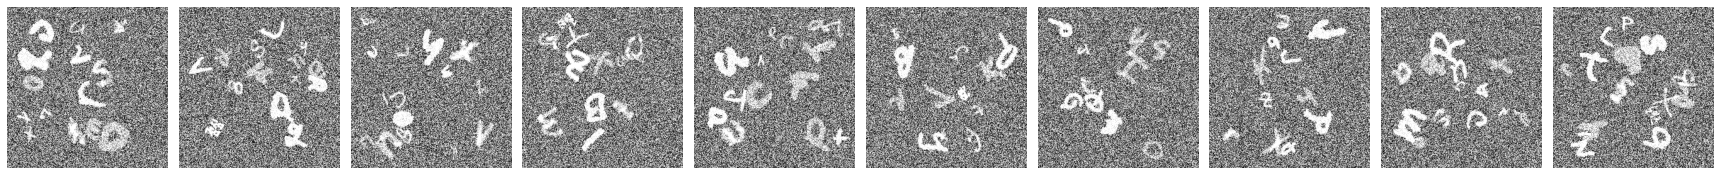

In [15]:
show_sample_image(10)

### 이미지 증강 

In [16]:
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

In [17]:
transform = albumentations.Compose([ToTensorV2()])

### 데이터셋 구축 

In [246]:
class BuildDataset(Dataset):
  def __init__(self, meatadata, transform=None):
    self.metadata = metadata
    self.transform = transform

  def __len__(self):
    return len(self.metadata)
    
  def __getitem__(self, idx):
    path = self.metadata['path'][idx]
    img = get_image(path)
    img = self.transform(image=img)['image']
    
    target = self.metadata.loc[idx, 'target']
    target = torch.tensor(target)

    return img, target

### 모델링 

In [247]:
from torchvision.models import resnet50

In [248]:
class ResNet50(nn.Module):
  def __init__(self):
    super().__init__()
    self.resnet = resnet50(pretrained=True)
    self.classifier = nn.Linear(1000, 26)

  def forward(self, x):
    x = self.resnet(x)
    x = self.classifier(x)
    return x

In [249]:
model = ResNet50()
model.to(device)

ResNet50(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

### 모델 훈련 

In [253]:
from sklearn.model_selection import train_test_split

In [254]:
train, valid = train_test_split(metadata,
                                test_size=0.2,
                                shuffle=True)

In [255]:
train_dataset = BuildDataset(train, transform)
valid_dataset = BuildDataset(valid, transform)

train_dataloader = DataLoader(train_dataset, batch_size=16)
valid_dataloader = DataLoader(valid_dataset, batch_size=16)

In [257]:
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MultiLabelSoftMarginLoss()

In [258]:
def to_device(img, target):
  img = img.to(device)
  target = target.to(device)
  return img, target

In [265]:
for epoch in range(epochs):
  iterator = tqdm(train_dataloader)
  for img, target in iterator:
    optimizer.zero_grad()

    img, target = to_device(img.float(), target)

    preds = model(img)
    loss = criterion(preds, target)

    loss.backward()
    optimizer.step()

    preds = preds > 0.5
    acc = (preds == target).float().mean()
    iterator.set_description(f'epoch:{epoch+1}, loss:{loss.item():.5f}, acc:{acc.item():.5f}')

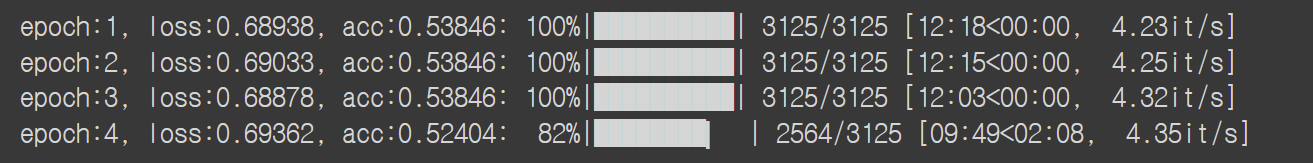

학습이 진행되지 않는다. 왜일까?

In [260]:
target

tensor([[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
         0, 1],
        [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
         1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
         1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
         0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
         0, 1],
        [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
         0, 0],
        [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
         1, 1],
        [0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
         1, 0],
        [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
         1, 0],
        [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
         1, 1],
        [1, 0, 1, 0, 0, 0, 1, 

In [262]:
target.shape

torch.Size([16, 26])

In [263]:
img.shape

torch.Size([16, 3, 256, 256])